In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cbpro as gdax


from backtest import Trader, historic_prices
from algorithms import SMA, EMA, MovingAverageAlgo

%matplotlib inline
client = gdax.PublicClient()

From: 2018-11-11T01:07:33, To: 2018-11-11T17:47:33
From: 2018-11-10T08:27:33, To: 2018-11-11T01:07:33
From: 2018-11-09T15:47:33, To: 2018-11-10T08:27:33
From: 2018-11-08T23:07:33, To: 2018-11-09T15:47:33
From: 2018-11-08T06:27:33, To: 2018-11-08T23:07:33
From: 2018-11-07T13:47:33, To: 2018-11-08T06:27:33
From: 2018-11-06T21:07:33, To: 2018-11-07T13:47:33
From: 2018-11-06T04:27:33, To: 2018-11-06T21:07:33
From: 2018-11-05T11:47:33, To: 2018-11-06T04:27:33
From: 2018-11-04T19:07:33, To: 2018-11-05T11:47:33
From: 2018-11-04T02:27:33, To: 2018-11-04T19:07:33
Last 10 prices: [6313.15, 6307.73, 6308.09, 6306.98, 6308.98, 6310, 6310, 6315.55, 6319, 6319.34]
2205
100.18166454091724
[6319.34, 6319, 6315.55, 6310, 6310, 6308.98, 6306.98, 6308.09, 6307.73, 6313.15]


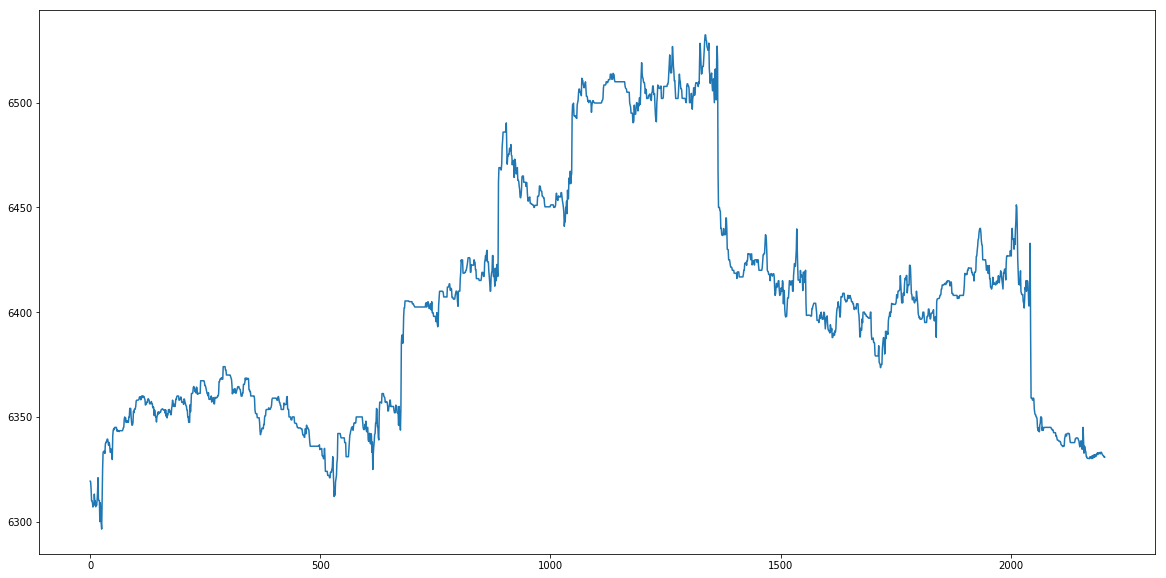

In [10]:
prices = historic_prices(client=client, product='BTC-USD', num_candles=2048, granularity=300)
prices.reverse()
print(len(prices))

prices_df = pd.Series(prices)

prices_df.plot(figsize=(20,10))
print(prices[-1]/prices[0] * 100)
print(prices[:10])

In [46]:
class Follower:
    def __init__(self, window=14, smooth=3):
        self.last_price = 0.0
        
    def tick(self, price):
        stance = price > self.last_price
        self.last_price = price
        return stance

In [29]:
class Trader:
    def __init__(self, fee=0.0, verbose=False):
        self.value = 100.
        self.cash = self.value
        self.invested = 0.
        self.last_price = 0
        self.num_trades = 0
        self.fee = fee
        self.tick_count = 0
        self.verbose = verbose
        self.buy_unit = 5.0
        self.sell_fraction = 0.25
        
    def tick(self, price):
        stance = False
        if self.last_price == 0:
            self.last_price = price
        else:
            stance = price > self.last_price
            
        delta = self.invested * ((price - self.last_price) / self.last_price)
        self.invested += delta
        self.value = self.cash + self.invested

        log = "{} - Price: {}, Stance: {}".format(self.tick_count, price, "In, " if stance else "Out, ")
        if stance:
            self.invested += self.buy_unit
            self.cash -= self.buy_unit *(1 + self.fee)
        else:
            to_sell = self.invested / self.sell_fraction
            self.invested -= to_sell
            self.cash += to_sell * (1 - self.fee)
            
        self.last_price = price
        log += "Value: {}".format(round(self.value, 2))
        if self.verbose: print(log)
        self.tick_count += 1
        
        return self.value, self.num_trades

In [30]:
potential = []
trader = Trader()
final = 0
for price in prices:
    final, _ = trader.tick(price)
    print(final)


100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
99.99971465213717
99.98682644033298
99.99182202911668
99.99182202911669
100.03292858825122
100.09073468703411
100.06020634468706
99.75928411298025
99.24691324038338
98.34732294725484
99.69230397458966
99.54971286280897
99.60752007028805
64.64572098724602
-28.89790215458197
10.118990943898098
-184.9654745485168
52.88150577980559
4356.600882115308
8076.013755749213
10258.787120700814
10472.289362627547
10475.098610547371
10503.1911686901
10205.409215574386
6438.1865822877735
5806.102839601226
5806.102839601226
8157.452161317691
9800.868866639212
9800.868866639212
21709.322861596942
-9009.937443822622
-101850.36858922243
-49286.301562964916
-563321.9180672169
382831.28840637207
3645216.695142746
1617745.5375461578
3718942.9190597534
-56828718.469192505
-613701319.2373657
-750057970.3616333
-783898307.1364746
-764489878.6923828
-600264714.9346924
-619673143.3789062
-691335033.019043
-686856164.9165039
-673419560.6083984
-3024825314.419922
-53

In [101]:
for sims in potential[:10]:
    print("{} - {} : {}".format(*sims))

2 - 2 : 105.5976331360946
2 - 3 : 105.5976331360946
2 - 4 : 105.5976331360946
2 - 5 : 105.5976331360946
2 - 6 : 105.5976331360946
2 - 7 : 105.5976331360946
2 - 8 : 105.5976331360946
2 - 9 : 105.5976331360946
2 - 10 : 105.5976331360946
2 - 11 : 105.5976331360946


/Users/rhanes/.miniconda2/envs/finance/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


99.50118517360839
99.55693975683815


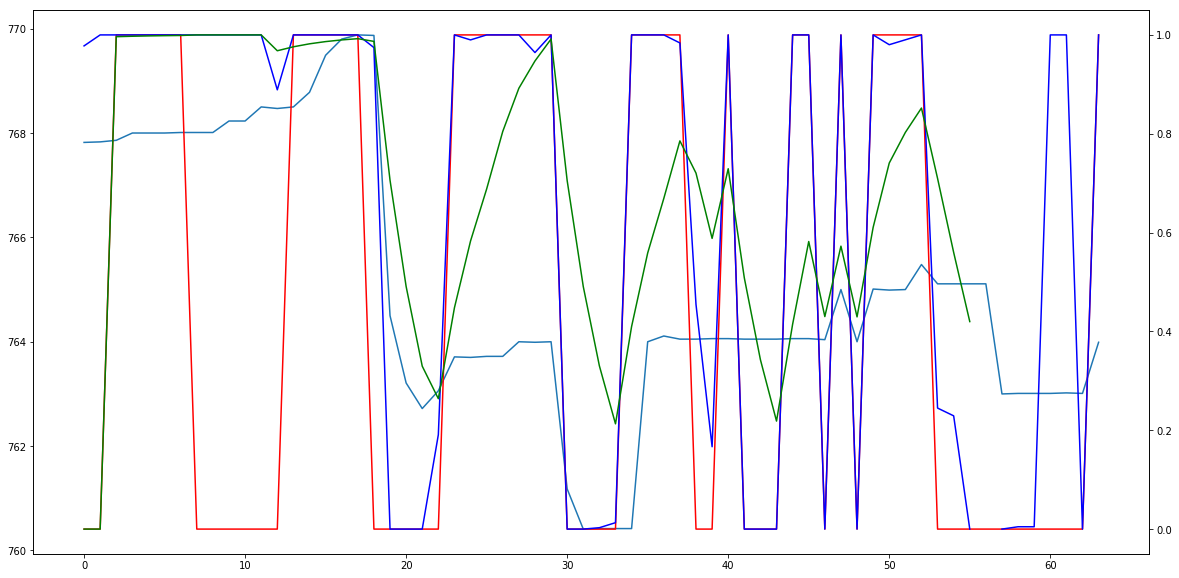

In [37]:
window = 4
smooth = 7

chart_back = 64
stances = []
sos = []
avgs = []

so = StochasticOscillator(window=4, smooth=7)
for price in prices[-(window + chart_back):]:
    stance, sov, avg = so.tick(price)
    stances.append(stance)
    sos.append(sov)
    avgs.append(avg)
    
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(prices[-chart_back:])
ax2.plot(stances[-chart_back:], "r")
ax2.plot(sos[-chart_back:], "b")
ax2.plot(avgs[-chart_back:], "g")
algo = StochasticOscillator()
trader = Trader(algo)
final = 0
for price in prices[-(window + chart_back):]:
    final, _ = trader.tick(price)
print(prices[-1]/prices[-chart_back] * 100)
print(final)

In [12]:
class InverseMovingAverage:
    def __init__(self, window):
        self.avg = SMA(window)
    def tick(self, price):
        ret = False
        avg_val = self.avg.tick(price)
        if avg_val:
            ret = avg_val > price
        return ret
        

In [30]:
look_back = 1000
slow_win = 250

potential = []
print(prices[-1]/prices[-look_back] * 100)

for window in range (5, 30, 1):
    for smooth in np.arange(3, 15, 1):
        cut = 1.1
        #for cut in np.arange(0.1, 0.9, 0.1):
        islow = InverseMovingAverage(slow_win)
        stoch = StochasticOscillator(window, smooth, cut)
        for price in prices[-(slow_win + look_back):-look_back]:
            islow.tick(price)
            stoch.tick(price)
        
        trader = DoubleTrader(islow, stoch)
        final = 0
        for price in prices[-look_back:]:
            final, _ = trader.tick(price)
        potential.append((window, smooth, cut, final))
potential.sort(key=lambda tup: tup[3], reverse=True)
for sims in potential[:10]:
    print("{} - {} - {}: {}".format(*sims))

146.02971982194293
5 - 3 - 1.1: 93.55346797040627
5 - 4 - 1.1: 93.55346797040627
5 - 5 - 1.1: 93.55346797040627
5 - 6 - 1.1: 93.55346797040627
5 - 7 - 1.1: 93.55346797040627
5 - 8 - 1.1: 93.55346797040627
5 - 9 - 1.1: 93.55346797040627
5 - 10 - 1.1: 93.55346797040627
5 - 11 - 1.1: 93.55346797040627
5 - 12 - 1.1: 93.55346797040627
